In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 이미지 불러오기

In [2]:
img_sticker_path = './cat-whiskers.png'
img_face_path = './me_2.jpg'

In [3]:
img_face_bgr = cv2.imread(img_face_path)  # 얼굴 이미지 불러오기
img_face_rgb = cv2.cvtColor(img_face_bgr, cv2.COLOR_BGR2RGB)  # rgb 이미지
img_face_show = img_face_bgr.copy()  # 작업용 이미지
img_face_org = img_face_bgr.copy()  # 초기화용 이미지

# 얼굴 인식

In [4]:
# 얼굴 인식 모듈
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_face_rgb, 1)

In [5]:
print(dlib_rects)

rectangles[[(469, 242) (655, 428)]]


In [ ]:
# 얼굴 인식된 부분 사각형 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_face_show, (l,t), (r,b), 
                  (0,255,0), 2, 
                  lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_face_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 모양 인식

In [7]:
# 얼굴 모양 인식 모델
model_path = './shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
# 얼굴 모양 인식
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_face_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

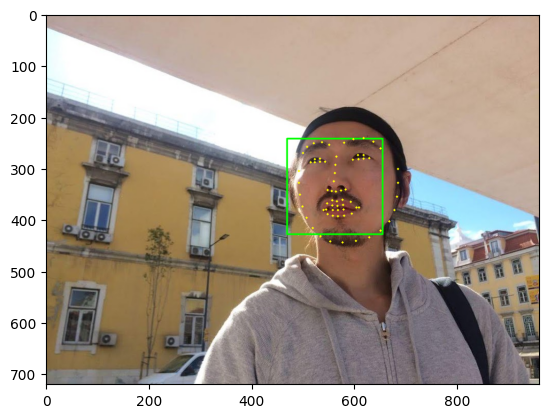

In [9]:
# 얼굴 모양 인식된 부분 점으로 표시
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_face_show, point, 
                   2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_face_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
# 코 위치 계산
nose_index = 30
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[nose_index])
    x = landmark[nose_index][0]
    y = landmark[nose_index][1]
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')    

(560, 325)
(x,y) : (560,325)
(w,h) : (187,187)


In [11]:
# 선 그리기
def draw_line(img, pt1, pt2, color=(255,255,255), size=2):
    cv2.line(img, pt1, pt2, color, size)

In [12]:
# 이미지 확인
def img_show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [13]:
# 코 위치 - 가로세로 선 표시
draw_line(img_face_show, (x,0), (x,img_face_show.shape[0]), (255,255,255), 2)
draw_line(img_face_show, (0,y), (img_face_show.shape[1], y), (255,255,255), 2)

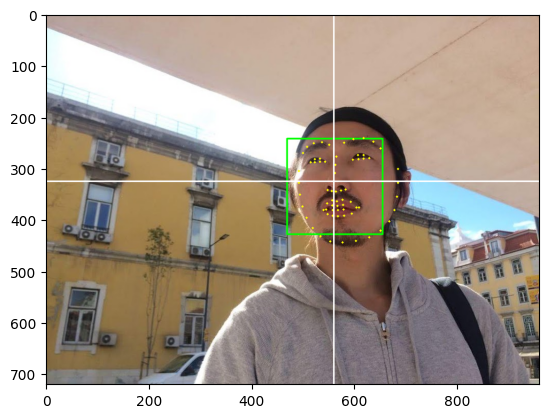

In [14]:
img_show(img_face_show)

# 스티커 이미지

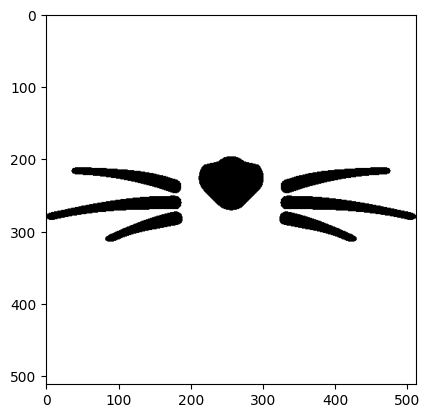

In [15]:
# 스티커 이미지 불러오기
img_sticker = cv2.imread(img_sticker_path)

plt.imshow(img_sticker)
plt.show()

In [16]:
# 얼굴 크기에 맞게 스티커 크기 조정
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(187, 187, 3)


In [17]:
refined_x = x - w // 2
refined_y = y - h // 2

print(f'(x, y): ({refined_x}, {refined_y})')

(x, y): (467, 232)


In [18]:
# 스티커 출력 위치에 사각형 표시
img_rect = cv2.rectangle(img_face_show, 
                         (refined_x, refined_y),
                         (refined_x + img_sticker.shape[1], refined_y + img_sticker.shape[0]),
                         (0,0,255), 2)

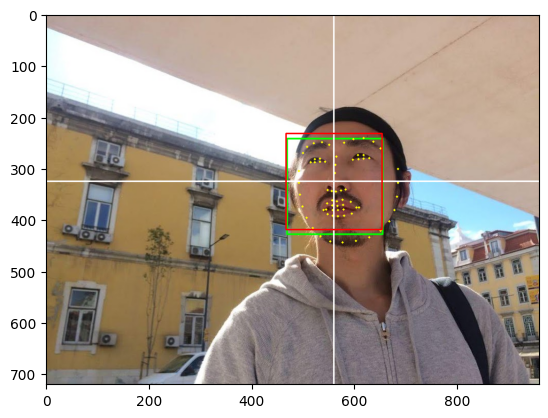

In [21]:
img_show(img_rect)

In [22]:
# 벗어나는 범위 처리
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print(f'(x, y): ({refined_x}, {refined_y})')

(x, y): (467, 232)


In [23]:
adj_y = 14  # 세로축 위치 조정값
refined_y += adj_y  # 세로축 위치 조정

In [24]:
# 계산된 위치에 스티커 출력
sticker_area = \
    img_face_show[refined_y:refined_y + img_sticker.shape[0],
                  refined_x:refined_x + img_sticker.shape[1]]

img_face_show[refined_y:refined_y + img_sticker.shape[0],
              refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

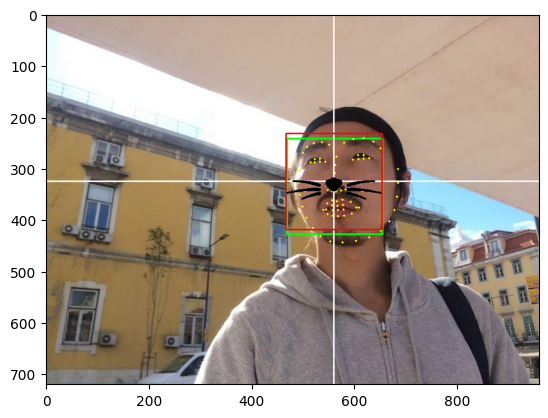

In [25]:
plt.imshow(cv2.cvtColor(img_face_show, cv2.COLOR_BGR2RGB))
plt.show()

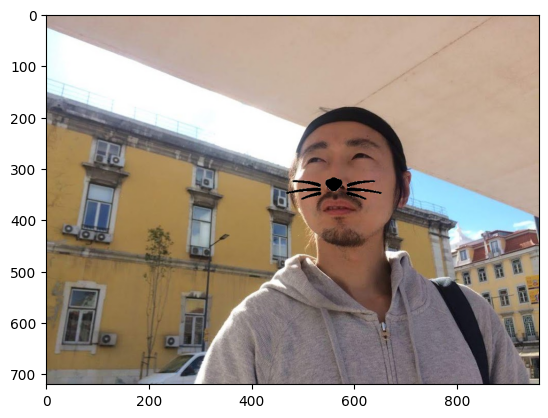

In [26]:
# 최종 이미지 출력
sticker_area = img_face_bgr[refined_y:refined_y + img_sticker.shape[0],
                            refined_x:refined_x + img_sticker.shape[1]]

img_face_bgr[refined_y:refined_y + img_sticker.shape[0], 
             refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_face_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 투명도 조정

In [27]:
img_face_bgr = img_face_org.copy()

In [28]:
# 스티커 부분 이미지
sticker_area = img_face_bgr[refined_y:refined_y + img_sticker.shape[0],
                            refined_x:refined_x + img_sticker.shape[1]]

In [29]:
# 마스킹 이미지
img_mask = np.where(img_sticker==0, sticker_area, 255).astype(np.uint8)

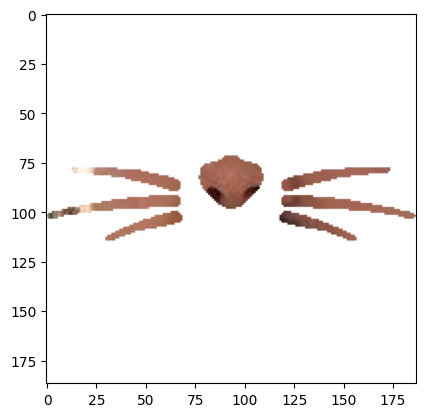

In [30]:
img_show(img_mask)

In [31]:
# 블렌딩, 7:3 비율
img_blend = cv2.addWeighted(img_mask, 0.7, img_sticker, 0.3, 0)

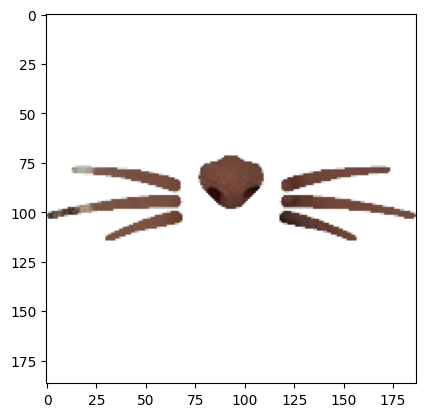

In [32]:
img_show(img_blend)

In [33]:
# 기존 이미지에 합성
img_merge = np.where(img_blend>200, sticker_area, img_blend).astype(np.uint8)

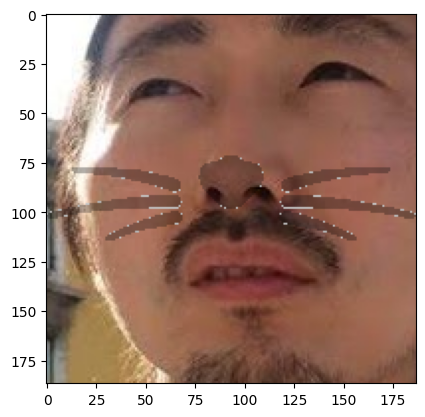

In [34]:
img_show(img_merge)

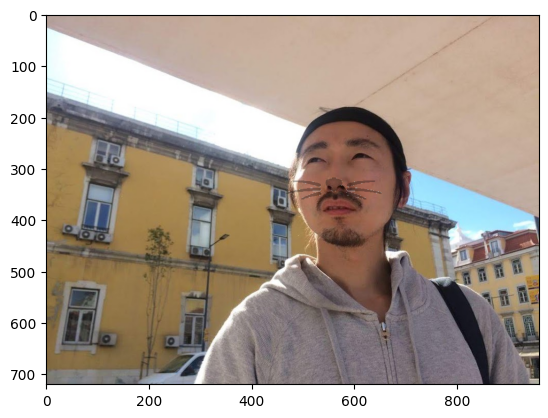

In [35]:
# 최종 이미지 출력
img_face_bgr[refined_y:refined_y + img_sticker.shape[0], 
             refined_x:refined_x + img_sticker.shape[1]] = img_merge
    
plt.imshow(cv2.cvtColor(img_face_bgr, cv2.COLOR_BGR2RGB))
plt.show()